**Курсовой проект для курса "Python для Data Science"**

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

**Подключение библиотек и скриптов**

In [237]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [238]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [239]:
DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'test.csv'
#Курсовая работа сделана в Google Collab, поэтому файлы подгружались в колаб вручную.

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

In [240]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [242]:
df.shape

(10000, 20)

In [243]:
df_test = pd.read_csv(PREPARED_DATASET_PATH, sep=',')
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [244]:
df_test.shape

(5000, 19)

# Шаг 2. Обработка данных <a class='anchor' id='load'>

In [245]:
# смотрим на структуру данных
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [246]:
# видим что данные не заполнены в двух столбцах LifeSquare Healthcare_1
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [247]:
#Замена пустых значений на медиану в столбце Healthcare_1
median = df['Healthcare_1'].median()
df['Healthcare_1'] = df['Healthcare_1'].fillna(median)

In [248]:
#Замена пустых значений на медиану в столбце LifeSquare
median = df['LifeSquare'].median()
df['LifeSquare'] = df['LifeSquare'].fillna(median)

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [250]:
df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [251]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [252]:
df_sort_room=df.sort_values(by='Rooms')
df_sort_room.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3911,770,28,0.0,49.483501,32.781260,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.918007
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.260887
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.110646
2269,7317,27,0.0,41.790881,32.781260,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976788
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.744389
4366,456,6,0.0,81.491446,32.781260,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
5141,656,26,1.0,56.472075,27.739383,13.0,10,30.0,2012,0.000000,B,B,36,6714,2,2672.0,0,2,B,304383.009406
5139,16780,42,1.0,40.893527,18.251862,10.0,4,24.0,2007,0.158249,B,B,21,5731,0,900.0,1,0,B,171531.569155


In [253]:
df_sort_sq=df.sort_values(by='Square')
df_sort_sq.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,181434.825589
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,900.0,1,11,B,458378.777006
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,900.0,0,0,B,126596.941798
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,900.0,3,2,B,438005.182323
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,900.0,0,1,B,97560.720383
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,900.0,0,1,B,161379.067034
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,900.0,0,0,B,107604.269441
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,237716.681261


In [254]:
#убираем строки из датафрейма с площадями квартир менее 10 кв.м.
df2=df[df.Square > 10]
df_sort_sq=df2.sort_values(by='Square')
df_sort_sq.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,78388.806186
7767,6927,21,1.0,16.117154,8.822988,0.0,2,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,79913.267856
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,1962,0.133215,B,B,49,11395,3,1406.0,3,4,A,77835.185808
3166,15127,150,1.0,17.046188,20.036232,8.0,7,12.0,1982,0.300323,B,B,52,10311,6,900.0,1,9,B,74222.110465
6945,12927,62,2.0,17.414181,32.781260,1.0,4,20.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,180750.471749
1891,13685,0,1.0,17.498542,13.446544,0.0,7,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,88871.750230
3794,523,101,1.0,18.509177,15.170851,3.0,5,5.0,1970,0.225825,A,B,41,6558,7,1548.0,3,2,B,115845.861527
7897,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.221700
9516,14236,0,1.0,19.927423,15.541536,0.0,2,5.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B,102395.788856
3084,3732,112,1.0,20.213128,13.800281,3.0,5,9.0,1974,0.069660,B,B,31,6119,4,900.0,1,2,B,113050.229914


In [255]:
#заменяем странные года постройки (типа 4968) на максимальный год из датафрейма 2020
df2.loc[df['HouseYear'] > 2020, 'HouseYear']=2020

In [256]:
df_sort=df2.sort_values(by='HouseYear')
df_sort.tail(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4493,14664,53,2.0,60.363889,43.142077,12.0,14,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,266202.142371
4376,6915,53,3.0,77.214218,56.678434,12.0,6,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,338025.692848
7459,2731,53,1.0,38.004250,24.259307,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,167829.123917
918,2530,53,2.0,64.233072,47.405440,13.0,13,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,283334.496716
3485,7026,62,1.0,44.019287,46.759316,1.0,7,12.0,2020,0.072158,B,B,2,629,1,900.0,0,0,A,135588.215289


In [257]:
df_sort=df2.sort_values(by='Price')
df_sort.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9732,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
3605,7243,9,2.0,58.089253,52.460857,8.0,5,22.0,1981,0.136244,B,B,11,2370,0,900.0,0,1,B,59877.592523
7850,8800,23,1.0,29.706031,32.781260,0.0,5,12.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,60502.583500
9961,1579,23,1.0,27.331108,32.781260,1.0,10,12.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,60825.032060
6856,2648,23,1.0,34.670830,32.781260,0.0,4,0.0,1977,0.005767,B,B,1,388,0,900.0,0,0,B,60828.260686


In [258]:
df2.shape

(9988, 20)

# Шаг 3. Разделение данных а фичи и таргет <a class='anchor' id='load'>

In [259]:
#Выбираем только числовые значения для построения модели
df_num = df2.select_dtypes(include=['float64', 'int64'])
df_num.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [260]:
#Убираем стоимость
x = df_num[df_num.columns[:-1]]
x.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,900.0,0,11
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4


In [261]:
y = pd.DataFrame(df2, columns=["Price"])
y.info

<bound method DataFrame.info of               Price
0     184966.930730
1     300009.450063
2     220925.908524
3     175616.227217
4     150226.531644
...             ...
9995  196684.316040
9996  189050.289571
9997  159143.805370
9998  181595.339808
9999  218714.077615

[9988 rows x 1 columns]>

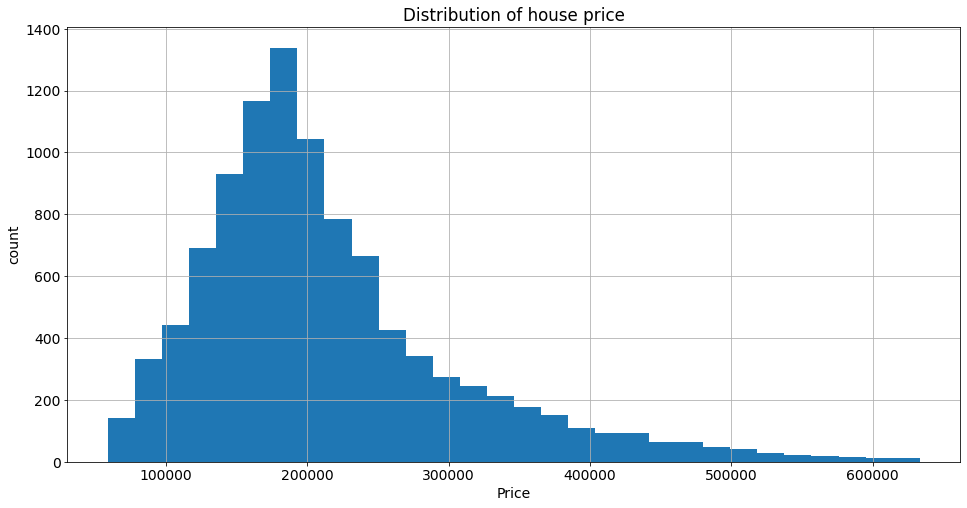

In [262]:
plt.figure(figsize = (16, 8))

y['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of house price')
plt.show()

In [263]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=100)

# Шаг 4.Построение моделей , их обучение и получение результатов метрики <a class='anchor' id='load'>

In [264]:
#Делаем предсказание по модели линейной регресии и смотрим метрику r2_score
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train, y_train)
y_pred=lr.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.4923514899283893

In [265]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
model =  RandomForestRegressor(n_estimators=1000 ,
                               max_features=16,
                              max_depth=12,
                               oob_score=True,
                               random_state=42)
model.fit(x_train, y_train.values[:, 0]) # обучение
a = model.predict(x_valid) # предсказание
r2_score(y_valid, a)

0.7226790587280225

In [266]:
model.feature_importances_

array([0.01834494, 0.04332286, 0.07532532, 0.40732297, 0.02121009,
       0.02445038, 0.02150176, 0.01874887, 0.02860307, 0.03628122,
       0.11067883, 0.09509187, 0.05629402, 0.02304233, 0.00504721,
       0.01473427])

In [267]:
feature_names = x.columns.tolist()
feature_names

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [268]:
feature_imp = pd.Series(model.feature_importances_, index=feature_names)
feature_imp

Id               0.018345
DistrictId       0.043323
Rooms            0.075325
Square           0.407323
LifeSquare       0.021210
KitchenSquare    0.024450
Floor            0.021502
HouseFloor       0.018749
HouseYear        0.028603
Ecology_1        0.036281
Social_1         0.110679
Social_2         0.095092
Social_3         0.056294
Healthcare_1     0.023042
Helthcare_2      0.005047
Shops_1          0.014734
dtype: float64

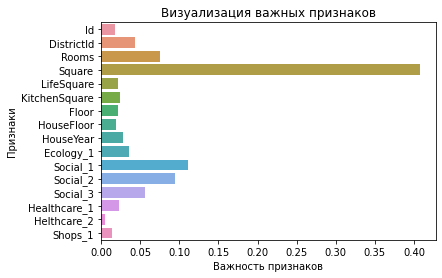

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp, y=feature_names)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

In [270]:
# Выберем 8 самых важных признаков и сделаем модель на них
#x2=x[x.columns[2:5]]
#x2.head()

x2=x.drop(['KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Healthcare_1', 'Helthcare_2', 'Shops_1'], axis=1)
x2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,Social_1,Social_2,Social_3
0,14038,35,2.0,47.981561,29.442751,33,7976,5
1,15053,41,3.0,65.683640,40.049543,46,10309,1
2,4765,53,2.0,44.947953,29.197612,34,7759,0
3,5809,58,2.0,53.352981,52.731512,23,5735,3
4,10783,99,1.0,39.649192,23.776169,35,5776,1


In [271]:
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(x2, y, test_size=0.3, random_state=100)

In [272]:
model_RF8=RandomForestRegressor(n_estimators=1000 ,
                               max_features=8,
                              max_depth=12,
                               oob_score=True,
                               random_state=42)
model_RF8.fit(x_train2, y_train2.values[:, 0]) # обучение
a = model_RF8.predict(x_valid2) # предсказание
r2_score(y_valid, a)
#на 8х параметрах точность модели ухудшилась

0.708121526558388

In [273]:
#Делаем предсказание по модели Случайный лес
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#param={'n_estimators': [60, 100, 150], 'max_features': [5, 6, 7, 8], 'max_depth': [5, 6, 7, 8, 9]}
param=[{'n_estimators':[100], 'max_features':[5], 'max_depth':[10] }]
clf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param,
    scoring = 'accuracy'
    #CV=5
)

In [274]:
clf.fit(x_train, y_train.values[:, 0])

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_depth': [10], 'max_features': [5],
                          'n_estimators': [100]}],
             scoring='accuracy')

In [275]:
clf.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 100}

In [276]:
y_pred_val=clf.predict(x_valid)
r2_score(y_valid, y_pred_val)
#{'max_depth': 10, 'max_features': 5, 'n_estimators': 100}                  0.7152232980231351
#{'max_depth': 10, 'max_features': 5, 'n_estimators': 10}                   0.6879075172764776
#{'max_depth': 10, 'max_features': 5, 'n_estimators': 60}                   0.7112312122037392
#Лучший результат {'max_depth': 10, 'max_features': 5, 'n_estimators': 100} 0.7152232980231351
#{'max_depth': 5, 'max_features': 5, 'n_estimators': 60}                    0.6206270212635754

0.7152232980231351

In [277]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(x_train, y_train)
y_train_preds = gb_model.predict(x_train)
r2_score(y_train, y_train_preds)

0.9005794875174038

In [278]:
#Градиентный бустинг мы изучали, но применять по заданию в данной курсовой не следует.
#Хотя он дает самый наилучний результат, метрика r2_core=0,90

# Шаг 5. Обработка тестовых данных <a class='anchor' id='load'>

In [279]:
# Приводим данные тестовой выборки в "нормальное " состояние

In [280]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [281]:
#Замена пустых значений на медиану в столбце LifeSquare
median = df_test['LifeSquare'].median()
df_test['LifeSquare'] = df_test['LifeSquare'].fillna(median)

In [282]:
#Замена пустых значений на медиану в столбце Healthcare_1
median = df_test['Healthcare_1'].median()
df_test['Healthcare_1'] = df_test['Healthcare_1'].fillna(median)

In [283]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [284]:
#Выбираем только числовые значения для построения предсказательной модели
df_test2 = df_test.select_dtypes(include=['float64', 'int64'])
df_test2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,900.0,0,0
1,15856,74,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,6,1437,3,900.0,0,2
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,900.0,3,3
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,2,629,1,900.0,0,0


# Шаг 6. Предсказание на модели Случайный лес и запись результата в файл<a class='anchor' id='load'>

In [285]:
#Лучшие предсказания выдает Градинтный бустинг, но его запрещено использовать в данной курсовой работе.
#Следующая по эффективости модель Случайный лес с о значением метрики 0.7226790587280225

In [286]:
y_pred_test=model.predict(df_test2)
y_pred_test

array([163272.21092786, 227990.64675741, 205313.12212621, ...,
       360205.99031762, 199175.43520731, 175347.90048887])

In [287]:
#Cоздаем дафтейм с ID тестовых квартир
pred_test = df_test2[df_test2.columns[:-15]]
pred_test.head()

,Id
0,725
1,15856
2,5480
3,15664
4,14275


In [288]:
data = np.array([y_pred_test])
data=data.transpose()
df_p = pd.DataFrame(data, columns =['Price']) 

In [289]:
df_p.head()

,Price
0,163272.210928
1,227990.646757
2,205313.122126
3,363176.238365
4,139354.870477


In [290]:
result = pd.concat([pred_test, df_p], axis=1, join='inner')
result.head()

,Id,Price
0,725,163272.210928
1,15856,227990.646757
2,5480,205313.122126
3,15664,363176.238365
4,14275,139354.870477


In [291]:
result.to_csv('Sivkov__predictions.csv', sep=',', index=False)

In [ ]:
#Время выполнения кода около 2-х минут.